In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,15
import seaborn as sns

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split,StratifiedShuffleSplit,StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score,accuracy_score ,confusion_matrix
from sklearn.preprocessing import KBinsDiscretizer

import warnings
warnings.filterwarnings("ignore")

from tqdm.notebook import tqdm ,tnrange

/kaggle/input/fast-v2-offline/torch-1.6.0-cp37-cp37m-manylinux1_x86_64.whl
/kaggle/input/fast-v2-offline/fastai-2.0.8-py3-none-any.whl
/kaggle/input/fast-v2-offline/dataclasses-0.6-py3-none-any.whl
/kaggle/input/fast-v2-offline/torchvision-0.7.0-cp37-cp37m-manylinux1_x86_64.whl
/kaggle/input/fast-v2-offline/fastcore-1.0.1-py3-none-any.whl
/kaggle/input/fast-v2-offline/fastprogress-1.0.0-py3-none-any.whl
/kaggle/input/avcrosssell/sample_submission.csv
/kaggle/input/avcrosssell/test.csv
/kaggle/input/avcrosssell/train.csv


In [2]:
train_data = pd.read_csv('/kaggle/input/avcrosssell/train.csv')

print(train_data.shape)

train_data.head()

(381109, 12)


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [3]:
test_data = pd.read_csv('/kaggle/input/avcrosssell/test.csv')

print(test_data.shape)

test_data.head()

(127037, 11)


,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
0,381110,Male,25,1,11.0,1,< 1 Year,No,35786.0,152.0,53
1,381111,Male,40,1,28.0,0,1-2 Year,Yes,33762.0,7.0,111
2,381112,Male,47,1,28.0,0,1-2 Year,Yes,40050.0,124.0,199
3,381113,Male,24,1,27.0,1,< 1 Year,Yes,37356.0,152.0,187
4,381114,Male,27,1,28.0,1,< 1 Year,No,59097.0,152.0,297


In [4]:
x = train_data[~train_data.iloc[:,1:].duplicated(keep = 'first')]

#confusing ids

train_data = train_data[~train_data.id.isin(x[x.iloc[:,1:-1].duplicated(keep = False)].id)]

In [5]:
def nullColumns(train_data):
    
    list_of_nullcolumns =[]
    
    for column in train_data.columns:
        
        total= train_data[column].isna().sum()
        
        try:
            
            if total !=0:
                
                print('Total Na values is {0} for column {1}' .format(total, column))
                
                list_of_nullcolumns.append(column)
        
        except:
            
            print(column,"-----",total)
    
    print('\n')
    
    return list_of_nullcolumns


def percentMissingFeature(data):
    
    data_na = (data.isnull().sum() / len(data)) * 100
    
    data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)[:30]
    
    missing_data = pd.DataFrame({'Missing Ratio' :data_na})
    
    return data_na


def plotMissingFeature(data_na):
    
    f, ax = plt.subplots(figsize=(15, 12))
    
    plt.xticks(rotation='90')
    
    if(data_na.empty ==False):
        
        sns.barplot(x=data_na.index, y=data_na)
        
        plt.xlabel('Features', fontsize=15)
        
        plt.ylabel('Percent of missing values', fontsize=15)
        
        plt.title('Percent missing data by feature', fontsize=15)

In [6]:
print('train data')

print(nullColumns(train_data))

print(percentMissingFeature(train_data))

print('\n')

print('test_data')

print(nullColumns(test_data))

print(percentMissingFeature(test_data))

train data


[]
Series([], dtype: float64)


test_data


[]
Series([], dtype: float64)


Text(0.5, 1.0, 'Response')

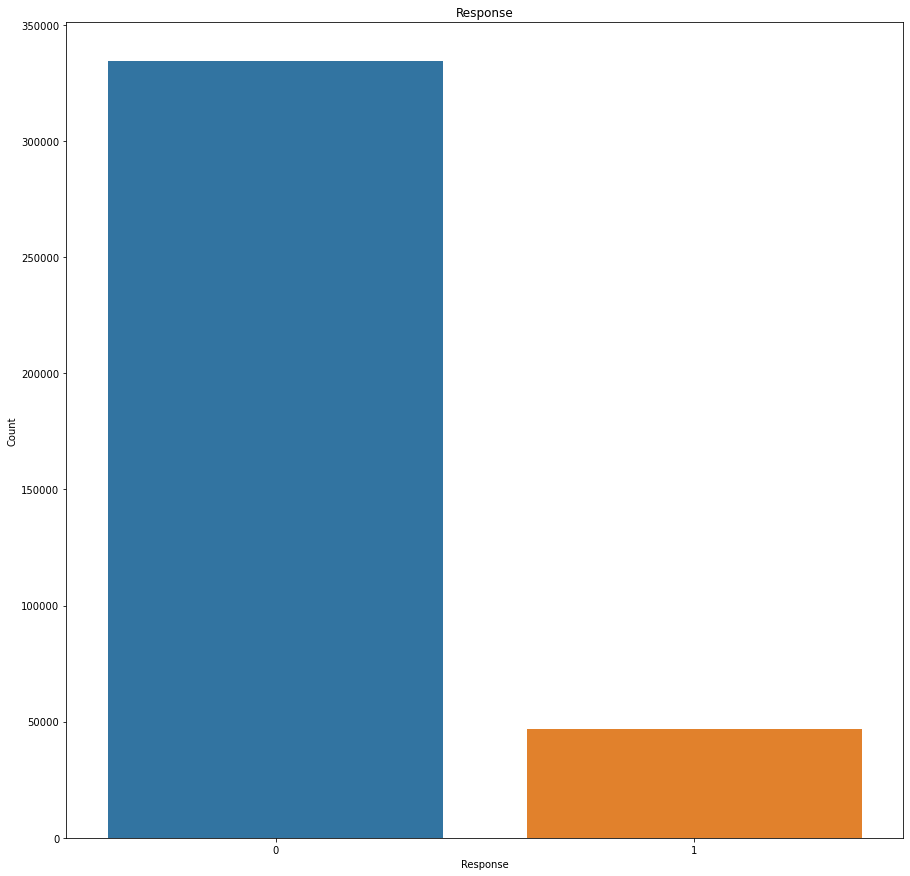

In [7]:
response = train_data.loc[:,"Response"].value_counts().rename('Count')
plt.xlabel("Response")
plt.ylabel('Count')
sns.barplot(response.index , response.values).set_title('Response')

In [8]:
response

0    334346
1     46657
Name: Count, dtype: int64

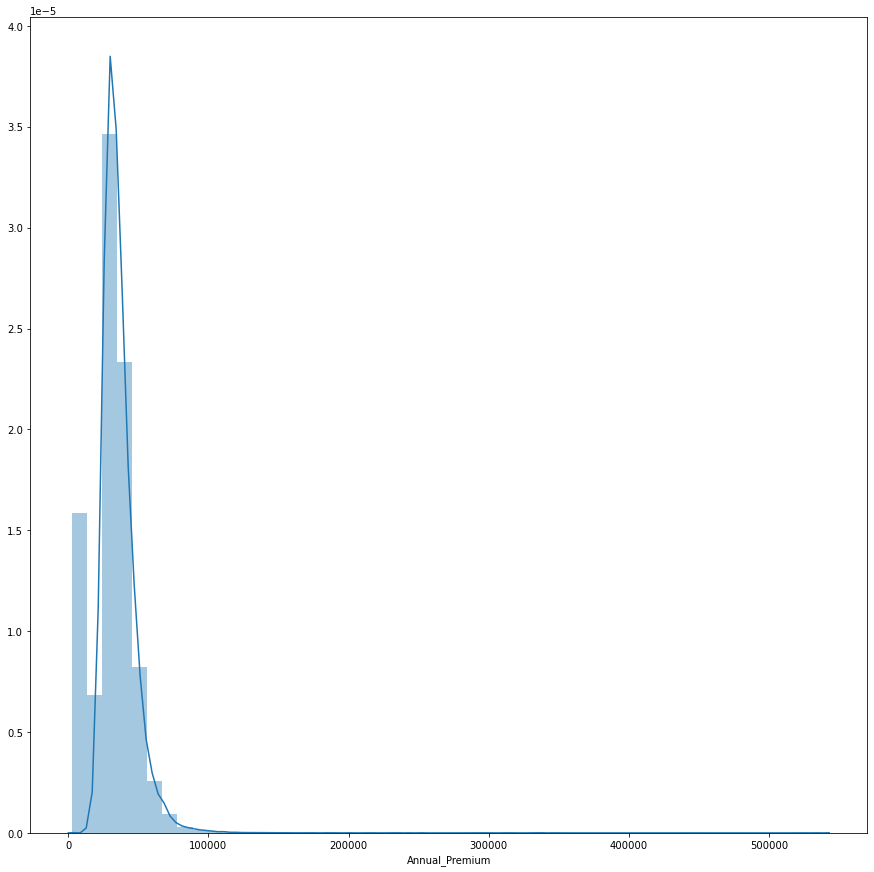

In [9]:
sns.distplot(train_data['Annual_Premium'])

# FE

In [10]:
train_data['Policy_Region'] = train_data['Policy_Sales_Channel'].astype(str)+'_'+train_data['Region_Code'].astype(str)

test_data['Policy_Region'] = test_data['Policy_Sales_Channel'].astype(str)+'_'+test_data['Region_Code'].astype(str)

train_data['Vehicle_Age_License'] = train_data['Vehicle_Age'].astype(str)+'_'+train_data['Driving_License'].astype(str)

test_data['Vehicle_Age_License'] = test_data['Vehicle_Age'].astype(str)+'_'+test_data['Driving_License'].astype(str)

In [11]:
cat_features = ['Gender','Driving_License','Region_Code','Previously_Insured',
                'Vehicle_Damage','Policy_Sales_Channel','Policy_Region',
                'Vehicle_Age','Vintage','Annual_Premium','Vehicle_Age_License']

cont_features = ['Age']

label = 'Response'

In [12]:
def encode_cat_cols(train, test, cat_cols): #target

    train_df = train_data.copy()
    
    test_df = test_data.copy()
    
    # Making a dictionary to store all the labelencoders for categroical columns to transform them later.
    
    le_dict = {}

    for col in cat_cols:
        
        if col!= 'Vehicle_Age':
        
            le = LabelEncoder()

            le.fit(train_df[col].unique().tolist() + test_df[col].unique().tolist())

            train_df[col] = le.transform(train_df[[col]])

            test_df[col] = le.transform(test_df[[col]])

            le_dict[col] = le
        
    train_df['Vehicle_Age'] = train_df['Vehicle_Age'].map({'< 1 Year':1,'1-2 Year':2,'> 2 Years':3})
    
    test_df['Vehicle_Age'] = test_df['Vehicle_Age'].map({'< 1 Year':1,'1-2 Year':2,'> 2 Years':3})

    le = LabelEncoder()
    
    train_df[label] = le.fit_transform(train_df[[label]])
    
    le_dict[label] = le
    
    
    return train_df, test_df, le_dict

In [13]:
train_df, test_df, le_dict = encode_cat_cols(train_data,test_data,cat_features)

In [14]:
train_df = train_df[~train_df.Policy_Sales_Channel.isin(list(set(train_df.Policy_Sales_Channel)-set(test_df.Policy_Sales_Channel)))]

#test_df.loc[(test_df.Policy_Sales_Channel.isin(list(set(test_df.Policy_Sales_Channel) - set(train_df.Policy_Sales_Channel)))),'Policy_Sales_Channel'] = -1

test_df.loc[(test_df.Policy_Sales_Channel==137),'Policy_Sales_Channel'] = -1

test_df.loc[(test_df.Policy_Sales_Channel==136),'Policy_Sales_Channel'] = -1

In [15]:
train_df['train'] = 1

test_df['train'] = 0

combined_data = pd.concat([train_df,test_df],axis =0).reset_index(drop = True).copy()

In [16]:
premium_discretizer = KBinsDiscretizer(n_bins=8, encode='ordinal', strategy='quantile')

combined_data['Premium_Bins'] =premium_discretizer.fit_transform(combined_data['Annual_Premium'].values.reshape(-1,1)).astype(int)

age_discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')

combined_data['Age_Bins'] =age_discretizer.fit_transform(combined_data['Age'].values.reshape(-1,1)).astype(int)

In [17]:
gender_counts = combined_data['Gender'].value_counts().to_dict()

combined_data['Gender_Counts'] = combined_data['Gender'].map(gender_counts)

region_counts = combined_data['Region_Code'].value_counts().to_dict()

combined_data['Region_counts'] = combined_data['Region_Code'].map(region_counts)

vehicle_age_counts = combined_data['Vehicle_Age'].value_counts().to_dict()

combined_data['Vehicle_Age_Counts'] = combined_data['Vehicle_Age'].map(vehicle_age_counts)

In [18]:
combined_data['Nunq_Policy_Per_Region'] = combined_data.groupby('Region_Code')['Policy_Sales_Channel'].transform('nunique') 

combined_data['SDev_Annual_Premium_Per_Region_Code_int'] = combined_data.groupby('Region_Code')['Annual_Premium'].transform('std').fillna(-1) 

combined_data['Nunq_Region_Per_Premium'] = combined_data.groupby('Annual_Premium')['Region_Code'].transform('nunique')

# 1230.45 can be split into “1230” and “45”. LGBM cannot see these pieces on its own, you need to split them.
combined_data['SDev_Annual_Premium_Per_Region_Code_dec'] = combined_data['SDev_Annual_Premium_Per_Region_Code_int'] %1

combined_data['SDev_Annual_Premium_Per_Region_Code_int'] =combined_data['SDev_Annual_Premium_Per_Region_Code_int'].astype(int)


combined_data['Avg_Policy_Region_Age'] = combined_data.groupby(['Policy_Region'])['Age'].transform('mean')

combined_data['Avg_Policy_Region_Premium'] = combined_data.groupby(['Policy_Region'])['Annual_Premium'].transform('mean') 

combined_data['Avg_Region_Premium'] = combined_data.groupby(['Region_Code'])['Annual_Premium'].transform('mean')

combined_data['Nunq_Premium_Region'] = combined_data.groupby(['Annual_Premium'])['Region_Code'].transform('nunique')

In [19]:
train_df = combined_data[combined_data['train']==1]

test_df = combined_data[combined_data['train']==0]

In [20]:
cols = ['Gender', 'Age', 'Driving_License', 'Region_Code',
       'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage',
        'Annual_Premium','Policy_Sales_Channel', 'Vintage']

train_df = train_df[~train_df.loc[:,cols].duplicated(keep = 'first')].reset_index(drop=True)

In [21]:
target = train_df['Response']

train_df = train_df.drop(columns =['train','id','Response'])

test_df = test_df.drop(columns=['train','id','Response'])

In [22]:
train_df.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,...,Region_counts,Vehicle_Age_Counts,Nunq_Policy_Per_Region,SDev_Annual_Premium_Per_Region_Code_int,Nunq_Region_Per_Premium,SDev_Annual_Premium_Per_Region_Code_dec,Avg_Policy_Region_Age,Avg_Policy_Region_Premium,Avg_Region_Premium,Nunq_Premium_Region
0,1,44,1,28,0,3,1,24158,24,207,...,141873,21323,121,12413,6,0.243217,51.397261,23898.593057,22686.813178,6
1,1,76,1,3,0,2,0,17240,24,173,...,12345,266897,64,9505,10,0.612352,50.517411,12237.779464,10938.390279,10
2,1,47,1,28,0,3,1,21998,24,17,...,141873,21323,121,12413,11,0.243217,51.397261,23898.593057,22686.813178,11
3,1,21,1,11,1,1,0,12323,147,193,...,12328,219792,53,9800,12,0.449872,25.735264,14232.640980,13361.517278,12
4,0,29,1,41,1,1,0,11200,147,29,...,24399,219792,67,10606,11,0.526628,26.792402,16507.378336,15963.029550,11


# CatBoost

In [23]:
trees = 5

n_splits = 5

seeds = [73]

submission = pd.read_csv('../input/avcrosssell/sample_submission.csv')

probs = np.zeros(shape=(len(test_df),))

# probablity file per seed per split per tree
submission_probs = pd.DataFrame(columns = ['id','Response'])

submission_probs.iloc[:,0] = submission.iloc[:,0]

submission_probs.iloc[:,1:] = 0

In [24]:
%%time

scores = []

avg_loss = []

submission_name = []

seed_no = []

fold_no = []

X_train_cv,y_train_cv = train_df.copy(), target.copy()


cat_features = ['Driving_License','Gender','Region_Code','Previously_Insured','Vehicle_Damage',
                'Policy_Sales_Channel','Policy_Region','Vehicle_Age','Vintage',
                'Annual_Premium','Vehicle_Age_License','Premium_Bins']

cont_features = ['Age','Age_Bins']

for seed in tnrange(len(seeds)):
    
    sssf = StratifiedShuffleSplit(n_splits=n_splits, test_size = 0.3 ,random_state=seeds[seed])

    for j, (idxT, idxV) in tqdm(enumerate(sssf.split(X_train_cv, y_train_cv))):

        print('Fold',j)

        print(' rows of train =',len(idxT),'rows of holdout =',len(idxV))

        model_cb = [0] *trees

        for i in tnrange(trees):
            
            seed_no.append(seeds[seed])
            
            fold_no.append(j)

            print('Tree',i)
            
            model_cb[i] = CatBoostClassifier(iterations=10000,
                                learning_rate=0.02,
                                random_strength=0.1,
                                depth=8,
                                loss_function='Logloss',
                                eval_metric='Logloss',
                                leaf_estimation_method='Newton',
                                random_state = i*27,
                                cat_features =cat_features,
                                subsample = 0.9,
                                rsm = 0.8
                                )
            model_cb[i].fit(X_train_cv.iloc[idxT], y_train_cv.iloc[idxT],
                    eval_set=[(X_train_cv.iloc[idxV],y_train_cv.iloc[idxV])],
                   early_stopping_rounds=50,verbose = 100)


            probs_file_name = 'probs_'+str(seeds[seed])+'_'+str(j)+'_'+str(i)+".csv"
            
            model_cb_probs = model_cb[i].predict_proba(test_df)[:,1]
            
            submission_probs.iloc[:,1:] = model_cb_probs
            
            # probablity file per seed per split per tree
            submission_probs.to_csv(probs_file_name,index = False)
            
            probs += model_cb_probs
            
            probs_oof = model_cb[i].predict_proba(X_train_cv.iloc[idxV])[:,1]
            
            roc = roc_auc_score(y_train_cv.iloc[idxV],probs_oof)

            scores.append(roc)

            avg_loss.append(model_cb[i].best_score_['validation']['Logloss'])
            
            submission_name.append(probs_file_name)
            
            print ('CB ROC OOF =',roc)
            
            print('#'*100)
    

print("Average Log Loss Stats {0:.5f},{1:.5f}".format(np.array(avg_loss).mean(), np.array(avg_loss).std()))


Fold 0
 rows of train = 266494 rows of holdout = 114213


Tree 0
0:	learn: 0.6544983	test: 0.6544527	best: 0.6544527 (0)	total: 621ms	remaining: 1h 43m 30s
100:	learn: 0.2666578	test: 0.2665018	best: 0.2665018 (100)	total: 45.1s	remaining: 1h 13m 42s
200:	learn: 0.2632765	test: 0.2638369	best: 0.2638369 (200)	total: 1m 34s	remaining: 1h 16m 39s
300:	learn: 0.2620651	test: 0.2634707	best: 0.2634707 (300)	total: 2m 22s	remaining: 1h 16m 40s
400:	learn: 0.2610853	test: 0.2633380	best: 0.2633357 (396)	total: 3m 15s	remaining: 1h 18m 5s
500:	learn: 0.2602751	test: 0.2632902	best: 0.2632893 (493)	total: 4m 9s	remaining: 1h 18m 46s
600:	learn: 0.2594547	test: 0.2632558	best: 0.2632542 (597)	total: 5m 4s	remaining: 1h 19m 16s
700:	learn: 0.2587090	test: 0.2632452	best: 0.2632452 (700)	total: 5m 55s	remaining: 1h 18m 34s
800:	learn: 0.2579627	test: 0.2632262	best: 0.2632261 (798)	total: 6m 52s	remaining: 1h 18m 59s
900:	learn: 0.2573275	test: 0.2632123	best: 0.2632061 (874)	total: 7m 44s	remaining: 1h 18m 14s
Stopped by overfitting detector  (50 itera

Tree 0
0:	learn: 0.6537504	test: 0.6537409	best: 0.6537409 (0)	total: 444ms	remaining: 1h 13m 58s
100:	learn: 0.2665890	test: 0.2668203	best: 0.2668203 (100)	total: 39.3s	remaining: 1h 4m 8s
200:	learn: 0.2632530	test: 0.2641536	best: 0.2641536 (200)	total: 1m 20s	remaining: 1h 5m 27s
300:	learn: 0.2621112	test: 0.2637854	best: 0.2637841 (298)	total: 2m 3s	remaining: 1h 6m 12s
400:	learn: 0.2612067	test: 0.2636299	best: 0.2636299 (400)	total: 2m 48s	remaining: 1h 7m 9s
500:	learn: 0.2603765	test: 0.2635639	best: 0.2635639 (500)	total: 3m 33s	remaining: 1h 7m 27s
600:	learn: 0.2596088	test: 0.2635024	best: 0.2635024 (600)	total: 4m 20s	remaining: 1h 7m 53s
700:	learn: 0.2588354	test: 0.2634523	best: 0.2634521 (699)	total: 5m 7s	remaining: 1h 8m 1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.2634302578
bestIteration = 737

Shrink model to first 738 iterations.
CB ROC OOF = 0.8599246912022509
#########################################################################

Tree 0
0:	learn: 0.6530415	test: 0.6530088	best: 0.6530088 (0)	total: 452ms	remaining: 1h 15m 18s
100:	learn: 0.2662215	test: 0.2672352	best: 0.2672352 (100)	total: 39.1s	remaining: 1h 3m 48s
200:	learn: 0.2629042	test: 0.2648229	best: 0.2648229 (200)	total: 1m 20s	remaining: 1h 5m 2s
300:	learn: 0.2616098	test: 0.2644821	best: 0.2644821 (300)	total: 2m 3s	remaining: 1h 6m 29s
400:	learn: 0.2606523	test: 0.2643598	best: 0.2643598 (400)	total: 2m 47s	remaining: 1h 6m 49s
500:	learn: 0.2598291	test: 0.2643061	best: 0.2643030 (498)	total: 3m 31s	remaining: 1h 6m 58s
600:	learn: 0.2591024	test: 0.2642846	best: 0.2642784 (559)	total: 4m 16s	remaining: 1h 6m 57s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.2642783778
bestIteration = 559

Shrink model to first 560 iterations.
CB ROC OOF = 0.8587588339256388
####################################################################################################
Tree 1
0:	learn: 0.6531950	test: 0.6531498	best: 0.6531498 (0)	t

Tree 0
0:	learn: 0.6541755	test: 0.6540738	best: 0.6540738 (0)	total: 445ms	remaining: 1h 14m 5s
100:	learn: 0.2665660	test: 0.2665441	best: 0.2665441 (100)	total: 48s	remaining: 1h 18m 21s
200:	learn: 0.2632189	test: 0.2641302	best: 0.2641302 (200)	total: 1m 30s	remaining: 1h 13m 29s
300:	learn: 0.2620516	test: 0.2638079	best: 0.2638079 (300)	total: 2m 14s	remaining: 1h 12m 10s
400:	learn: 0.2611533	test: 0.2636714	best: 0.2636714 (400)	total: 2m 59s	remaining: 1h 11m 27s
500:	learn: 0.2603799	test: 0.2636154	best: 0.2636152 (499)	total: 3m 43s	remaining: 1h 10m 35s
600:	learn: 0.2595954	test: 0.2635656	best: 0.2635635 (598)	total: 4m 30s	remaining: 1h 10m 25s
700:	learn: 0.2588725	test: 0.2635201	best: 0.2635195 (695)	total: 5m 16s	remaining: 1h 10m 4s
800:	learn: 0.2581526	test: 0.2635022	best: 0.2635005 (776)	total: 6m 3s	remaining: 1h 9m 33s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.263500548
bestIteration = 776

Shrink model to first 777 iterations.
CB R

Tree 0
0:	learn: 0.6536001	test: 0.6535840	best: 0.6535840 (0)	total: 465ms	remaining: 1h 17m 30s
100:	learn: 0.2661378	test: 0.2672948	best: 0.2672948 (100)	total: 39.2s	remaining: 1h 4m 3s
200:	learn: 0.2629136	test: 0.2648863	best: 0.2648863 (200)	total: 1m 20s	remaining: 1h 5m 27s
300:	learn: 0.2616236	test: 0.2645278	best: 0.2645278 (300)	total: 2m 3s	remaining: 1h 6m 13s
400:	learn: 0.2607992	test: 0.2644169	best: 0.2644161 (399)	total: 2m 47s	remaining: 1h 6m 46s
500:	learn: 0.2600493	test: 0.2643199	best: 0.2643199 (500)	total: 3m 31s	remaining: 1h 6m 45s
600:	learn: 0.2593021	test: 0.2642577	best: 0.2642574 (591)	total: 4m 15s	remaining: 1h 6m 36s
700:	learn: 0.2585392	test: 0.2642281	best: 0.2642280 (691)	total: 5m 2s	remaining: 1h 6m 47s
800:	learn: 0.2578152	test: 0.2642103	best: 0.2642016 (787)	total: 5m 58s	remaining: 1h 8m 36s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.2642015727
bestIteration = 787

Shrink model to first 788 iterations.
CB ROC O

In [25]:
submission_probs.iloc[:,1:] = probs/(len(seeds)*trees*n_splits)

# probablity combined
submission_probs.to_csv('probs.csv',index =False)

In [26]:
model_stats = pd.DataFrame({'submission':submission_name,'seed': seed_no,'fold':fold_no,'oof_roc':scores,'validation_loss':avg_loss})

model_stats.to_csv('model_stats.csv',index =False)

model_stats.head()

,submission,seed,fold,oof_roc,validation_loss
0,probs_73_0_0.csv,73,0,0.859732,0.263206
1,probs_73_0_1.csv,73,0,0.859810,0.263250
2,probs_73_0_2.csv,73,0,0.859731,0.263176
3,probs_73_0_3.csv,73,0,0.859773,0.263199
4,probs_73_0_4.csv,73,0,0.859912,0.263144
